In [2]:
import numpy as np


* n_x      → number of features per time step (e.g. embedding length) (input size)

* n_a     → number of neurons in the hidden state (memory size)

* n_y      → number of output classes or values (output size)

* m       → number of sequences processed in parallel  (batch size)

* T_x      → number of time steps (words, frames, etc.)  (sequence length) 

* X (n_x , m, T_x )
→ full input sequence (all time steps, all examples)

  * x(t) (n_x , m)
→ input at time step t

* A (n_a , m, T_x)
→ all hidden states over time

  * a(t) (n_a , m)
→ hidden state at time t (current memory)

* h_prev = a(t−1) (n_a , m)
→ hidden state from previous time step

* Y (n_y , m,  T_x)
→ outputs for all time steps

  * y(t) (n_y , m)
→ output at time step t

Hidden update:


* W_xh (n_a , n_x) → input → hidden weights
* W_hh (n_a , n_a) → hidden → hidden weights
* b_h (n_a , 1) → hidden bias

Output layer:

* W_hy (n_y , n_a) → hidden → output weights

* b_y (n_y , 1) → output bias


In [3]:
def softmax(x):
    e_x = np.exp(x - np.max(x, axis=0, keepdims=True))
    return e_x / e_x.sum(axis=0, keepdims=True)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [4]:
def rnn_cell_forward(xt, a_prev, parameters):
    """
    Implements a single forward step of the RNN-cell

    Arguments:
    xt -- your input data at timestep "t", numpy array of shape (n_x, m).
    a_prev -- Hidden state at timestep "t-1", numpy array of shape (n_a, m)
    parameters -- python dictionary containing:
                        Wax -- Weight matrix multiplying the input, numpy array of shape (n_a, n_x)
                        Waa -- Weight matrix multiplying the hidden state, numpy array of shape (n_a, n_a)
                        Wya -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
                        ba --  Bias, numpy array of shape (n_a, 1)
                        by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)
    Returns:
    a_next -- next hidden state, of shape (n_a, m)
    yt_pred -- prediction at timestep "t", numpy array of shape (n_y, m)
    cache -- tuple of values needed for the backward pass, contains (a_next, a_prev, xt, parameters)
    """
    
    # Retrieve parameters from "parameters"
    Wax = parameters["Wax"]
    Waa = parameters["Waa"]
    Wya = parameters["Wya"]
    ba = parameters["ba"]
    by = parameters["by"]
    
    a_next = np.tanh(np.dot(Waa,a_prev) + np.dot(Wax,xt) + ba)
    yt_pred = softmax(np.dot(Wya,a_next) + by)   
    
    # store values you need for backward propagation in cache
    cache = (a_next, a_prev, xt, parameters)
    
    return a_next, yt_pred, cache

In [5]:
def rnn_forward(x, a0, parameters):
    """
    Implement the forward propagation of the recurrent neural network (RNN)

    Arguments:
    x -- Input data for every time-step, of shape (n_x, m, T_x).
    a0 -- Initial hidden state, of shape (n_a, m)
    parameters -- python dictionary containing:
                        Waa -- Weight matrix multiplying the hidden state, numpy array of shape (n_a, n_a)
                        Wax -- Weight matrix multiplying the input, numpy array of shape (n_a, n_x)
                        Wya -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
                        ba --  Bias numpy array of shape (n_a, 1)
                        by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)

    Returns:
    a -- Hidden states for every time-step, numpy array of shape (n_a, m, T_x)
    y_pred -- Predictions for every time-step, numpy array of shape (n_y, m, T_x)
    caches -- tuple of values needed for the backward pass, contains (list of caches, x)
    """
    
    # Initialize "caches" which will contain the list of all caches
    caches = []
    
    n_x, m, T_x = x.shape
    n_y, n_a = parameters["Wya"].shape
    
    
    a = np.zeros([n_a,m,T_x])
    y_pred = np.zeros([n_y,m,T_x])
    
    a_next = a0
    
    # loop over all time-steps
    for t in range(T_x):
        a_next, yt_pred, cache = rnn_cell_forward(x[:,:,t], a_next, parameters)
        a[:,:,t] = a_next
        y_pred[:,:,t] = yt_pred
        caches.append(cache)
        
    
    caches = (caches, x)
    
    return a, y_pred, caches

In [6]:
def lstm_cell_forward(xt, a_prev, c_prev, parameters):
    """
    Implement a single forward step of the LSTM-cell 

    Arguments:
    xt -- your input data at timestep "t", numpy array of shape (n_x, m).
    a_prev -- Hidden state at timestep "t-1", numpy array of shape (n_a, m)
    c_prev -- Memory state at timestep "t-1", numpy array of shape (n_a, m)
    parameters -- python dictionary containing:
                        Wf -- Weight matrix of the forget gate, numpy array of shape (n_a, n_a + n_x)
                        bf -- Bias of the forget gate, numpy array of shape (n_a, 1)
                        Wi -- Weight matrix of the update gate, numpy array of shape (n_a, n_a + n_x)
                        bi -- Bias of the update gate, numpy array of shape (n_a, 1)
                        Wc -- Weight matrix of the first "tanh", numpy array of shape (n_a, n_a + n_x)
                        bc --  Bias of the first "tanh", numpy array of shape (n_a, 1)
                        Wo -- Weight matrix of the output gate, numpy array of shape (n_a, n_a + n_x)
                        bo --  Bias of the output gate, numpy array of shape (n_a, 1)
                        Wy -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
                        by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)
                        
    Returns:
    a_next -- next hidden state, of shape (n_a, m)
    c_next -- next memory state, of shape (n_a, m)
    yt_pred -- prediction at timestep "t", numpy array of shape (n_y, m)
    cache -- tuple of values needed for the backward pass, contains (a_next, c_next, a_prev, c_prev, xt, parameters)
    
    Note: ft/it/ot stand for the forget/update/output gates, cct stands for the candidate value (c tilde),
          c stands for the cell state (memory)
    """

    # Retrieve parameters from "parameters"
    Wf = parameters["Wf"] # forget gate weight
    bf = parameters["bf"]
    Wi = parameters["Wi"] # update gate weight 
    bi = parameters["bi"] 
    Wc = parameters["Wc"] # candidate value weight
    bc = parameters["bc"]
    Wo = parameters["Wo"] # output gate weight
    bo = parameters["bo"]
    Wy = parameters["Wy"] # prediction weight
    by = parameters["by"]
    
    n_x, m = xt.shape
    n_y, n_a = Wy.shape

    
    concat = np.zeros([n_x+n_a,m])
    concat[: n_a, :] = a_prev
    concat[n_a :, :] = xt

    ft = sigmoid(np.dot(Wf,concat)+bf)
    it = sigmoid(np.dot(Wi,concat)+bi)
    cct = np.tanh(np.dot(Wc,concat)+bc)
    c_next = ft*c_prev +it*cct
    ot = sigmoid(np.dot(Wo,concat)+bo)
    a_next = ot*np.tanh(c_next)
    
    
    yt_pred = softmax(np.dot(Wy,a_next)+by)

    cache = (a_next, c_next, a_prev, c_prev, ft, it, cct, ot, xt, parameters)

    return a_next, c_next, yt_pred, cache

In [7]:
def lstm_forward(x, a0, parameters):
    """
    Implement the forward propagation of the recurrent neural network using an LSTM-cell 

    Arguments:
    x -- Input data for every time-step, of shape (n_x, m, T_x).
    a0 -- Initial hidden state, of shape (n_a, m)
    parameters -- python dictionary containing:
                        Wf -- Weight matrix of the forget gate, numpy array of shape (n_a, n_a + n_x)
                        bf -- Bias of the forget gate, numpy array of shape (n_a, 1)
                        Wi -- Weight matrix of the update gate, numpy array of shape (n_a, n_a + n_x)
                        bi -- Bias of the update gate, numpy array of shape (n_a, 1)
                        Wc -- Weight matrix of the first "tanh", numpy array of shape (n_a, n_a + n_x)
                        bc -- Bias of the first "tanh", numpy array of shape (n_a, 1)
                        Wo -- Weight matrix of the output gate, numpy array of shape (n_a, n_a + n_x)
                        bo -- Bias of the output gate, numpy array of shape (n_a, 1)
                        Wy -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_y, n_a)
                        by -- Bias relating the hidden-state to the output, numpy array of shape (n_y, 1)
                        
    Returns:
    a -- Hidden states for every time-step, numpy array of shape (n_a, m, T_x)
    y -- Predictions for every time-step, numpy array of shape (n_y, m, T_x)
    c -- The value of the cell state, numpy array of shape (n_a, m, T_x)
    caches -- tuple of values needed for the backward pass, contains (list of all the caches, x)
    """

    caches = []
    
    Wy = parameters['Wy'] 
    n_x, m, T_x = x.shape
    n_y, n_a = Wy.shape
    
    a = np.zeros([n_a, m, T_x])
    c = np.zeros([n_a, m, T_x])
    y = np.zeros([n_y, m, T_x])
    
    a_next = a0
    c_next = np.zeros([n_a,m])
    
    for t in range(T_x):
        a_next, c_next, yt, cache = lstm_cell_forward(x[:,:,t], a_next, c_next, parameters)
        a[:,:,t] = a_next
        y[:,:,t] = yt
        c[:,:,t]  = c_next
        caches.append(cache)
        
    caches = (caches, x)

    return a, y, c, caches

# RNN backward

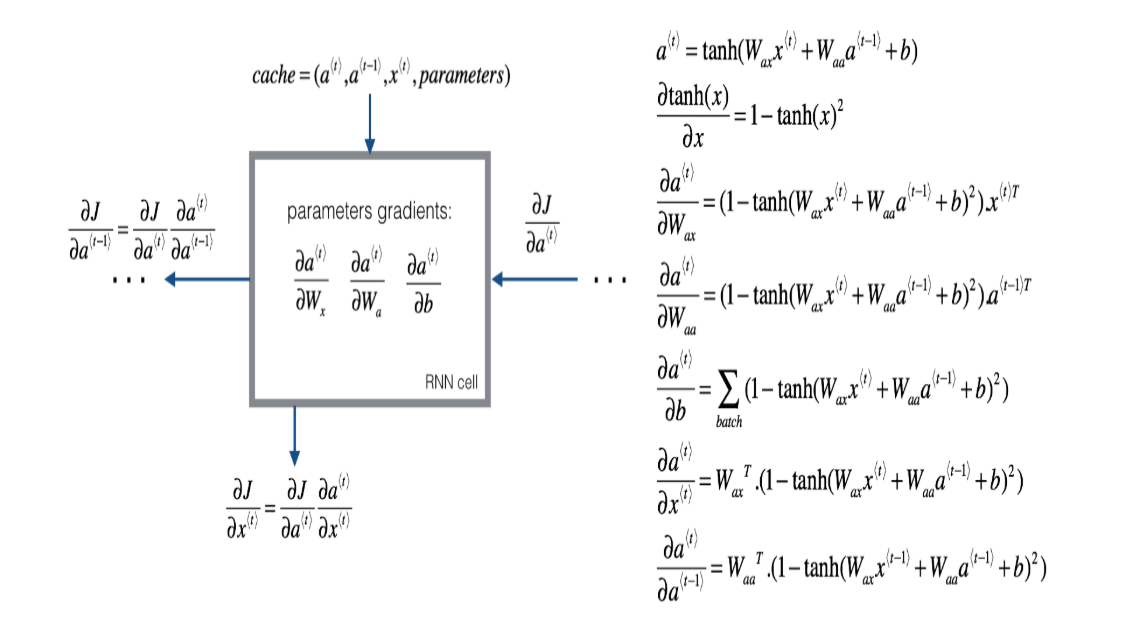

In [8]:
def rnn_cell_backward(da_next, cache):
    """
    Implements the backward pass for the RNN-cell (single time-step).

    Arguments:
    da_next -- Gradient of loss with respect to next hidden state
    cache -- python dictionary containing useful values (output of rnn_cell_forward())

    Returns:
    gradients -- python dictionary containing:
                        dx -- Gradients of input data, of shape (n_x, m)
                        da_prev -- Gradients of previous hidden state, of shape (n_a, m)
                        dWax -- Gradients of input-to-hidden weights, of shape (n_a, n_x)
                        dWaa -- Gradients of hidden-to-hidden weights, of shape (n_a, n_a)
                        dba -- Gradients of bias vector, of shape (n_a, 1)
    """
    
    # Retrieve values from cache
    (a_next, a_prev, xt, parameters) = cache
    
    # Retrieve values from parameters
    Wax = parameters["Wax"]
    Waa = parameters["Waa"]
    Wya = parameters["Wya"]
    ba = parameters["ba"]
    by = parameters["by"]

    # compute the gradient of tanh with respect to a_next 
    dtanh = (1-a_next*a_next)*da_next

    # compute the gradient of the loss with respect to Wax 
    dxt = np.dot(Wax.T,  dtanh)
    dWax = np.dot(dtanh,xt.T)

    # compute the gradient with respect to Waa 
    da_prev = np.dot(Waa.T, dtanh)  
    dWaa = np.dot( dtanh,a_prev.T)

    # compute the gradient with respect to b 
    dba = np.sum( dtanh,keepdims=True,axis=-1)

    
    # Store the gradients in a dictionary
    gradients = {"dxt": dxt, "da_prev": da_prev, "dWax": dWax, "dWaa": dWaa, "dba": dba}
    
    return gradients

In [9]:
def rnn_backward(da, caches):
    """
    Implement the backward pass for a RNN over an entire sequence of input data.

    Arguments:
    da -- Upstream gradients of all hidden states, of shape (n_a, m, T_x)
    caches -- tuple containing information from the forward pass (rnn_forward)
    
    Returns:
    gradients -- python dictionary containing:
                        dx -- Gradient w.r.t. the input data, numpy-array of shape (n_x, m, T_x)
                        da0 -- Gradient w.r.t the initial hidden state, numpy-array of shape (n_a, m)
                        dWax -- Gradient w.r.t the input's weight matrix, numpy-array of shape (n_a, n_x)
                        dWaa -- Gradient w.r.t the hidden state's weight matrix, numpy array of shape (n_a, n_a)
                        dba -- Gradient w.r.t the bias, of shape (n_a, 1)
    """
        
    
    # Retrieve values from the first cache (t=1) of caches 
    (caches, x) = caches
    (a1, a0, x1, parameters) = caches[0]
    
    # Retrieve dimensions from da's and x1's shapes 
    n_a, m, T_x = da.shape
    n_x, m = x1.shape 
    
    # initialize the gradients with the right sizes 
    dx = np.zeros((n_x, m, T_x)) 
    dWax = np.zeros((n_a, n_x))
    dWaa = np.zeros((n_a, n_a))
    dba = np.zeros((n_a, 1)) 
    da0 = np.zeros((n_a, m))
    da_prevt = np.zeros((n_a, m))  
    
    # Loop through all the time steps
    for t in reversed(range(T_x)):
        # Compute gradients at time step t.. 
        gradients = rnn_cell_backward(da[:, :, t] + da_prevt, caches[t])
        # Retrieve derivatives from gradients 
        dxt, da_prevt, dWaxt, dWaat, dbat = gradients["dxt"], gradients["da_prev"], gradients["dWax"], gradients["dWaa"], gradients["dba"]
        # Increment global derivatives w.r.t parameters by adding their derivative at time-step t 
        dx[:, :, t] = dxt  
        dWax += dWaxt  
        dWaa += dWaat  
        dba += dbat  
        
    # Set da0 to the gradient of a which has been backpropagated through all time-steps 
    da0 = da_prevt

    # Store the gradients in a dictionary
    gradients = {"dx": dx, "da0": da0, "dWax": dWax, "dWaa": dWaa,"dba": dba}
    
    return gradients

# LSTM Backward

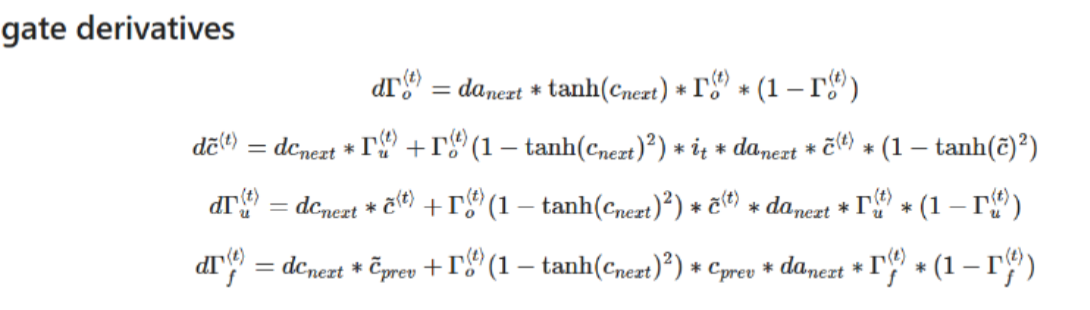


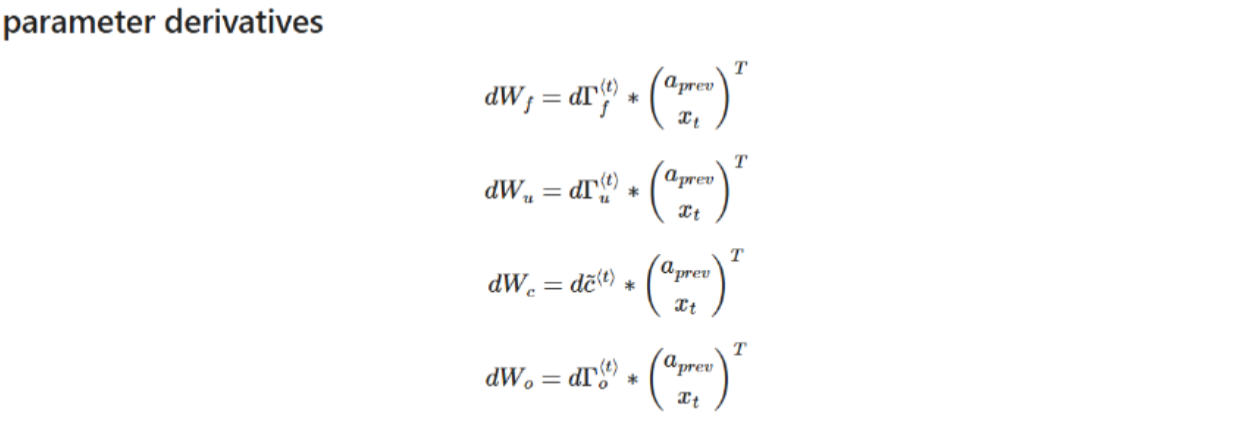

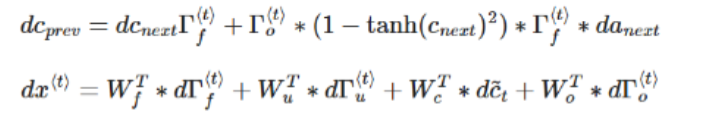

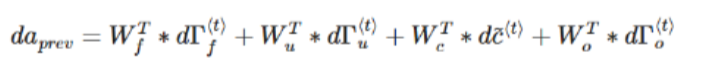

In [10]:
def lstm_cell_backward(da_next, dc_next, cache):
    """
    Implement the backward pass for the LSTM-cell (single time-step).

    Arguments:
    da_next -- Gradients of next hidden state, of shape (n_a, m)
    dc_next -- Gradients of next cell state, of shape (n_a, m)
    cache -- cache storing information from the forward pass

    Returns:
    gradients -- python dictionary containing:
                        dxt -- Gradient of input data at time-step t, of shape (n_x, m)
                        da_prev -- Gradient w.r.t. the previous hidden state, numpy array of shape (n_a, m)
                        dc_prev -- Gradient w.r.t. the previous memory state, of shape (n_a, m, T_x)
                        dWf -- Gradient w.r.t. the weight matrix of the forget gate, numpy array of shape (n_a, n_a + n_x)
                        dWi -- Gradient w.r.t. the weight matrix of the update gate, numpy array of shape (n_a, n_a + n_x)
                        dWc -- Gradient w.r.t. the weight matrix of the memory gate, numpy array of shape (n_a, n_a + n_x)
                        dWo -- Gradient w.r.t. the weight matrix of the output gate, numpy array of shape (n_a, n_a + n_x)
                        dbf -- Gradient w.r.t. biases of the forget gate, of shape (n_a, 1)
                        dbi -- Gradient w.r.t. biases of the update gate, of shape (n_a, 1)
                        dbc -- Gradient w.r.t. biases of the memory gate, of shape (n_a, 1)
                        dbo -- Gradient w.r.t. biases of the output gate, of shape (n_a, 1)
    """

    # Retrieve information from "cache"
    (a_next, c_next, a_prev, c_prev, ft, it, cct, ot, xt, parameters) = cache
    
    # Retrieve dimensions from xt's and a_next's shape 
    n_x, m = xt.shape 
    n_a, m = a_next.shape 
    
    # Compute gates related derivatives
    dit = (da_next * ot * (1 - np.tanh(c_next) ** 2) + dc_next) * cct * (1 - it) * it
    dft = (da_next * ot * (1 - np.tanh(c_next) ** 2) + dc_next) * c_prev * ft * (1 - ft)
    dot = da_next * np.tanh(c_next) * ot * (1 - ot)
    dcct = (da_next * ot * (1 - np.tanh(c_next) ** 2) + dc_next) * it * (1 - cct ** 2)

    # Compute parameters related derivatives.
    dWf = np.dot(dft,np.concatenate((a_prev, xt), axis=0).T) # or use np.dot(dft, np.hstack([a_prev.T, xt.T]))
    dWi = np.dot(dit,np.concatenate((a_prev, xt), axis=0).T)
    dWc = np.dot(dcct,np.concatenate((a_prev, xt), axis=0).T)
    dWo = np.dot(dot,np.concatenate((a_prev, xt), axis=0).T)
    dbf = np.sum(dft,axis=1,keepdims=True)
    dbi = np.sum(dit,axis=1,keepdims=True) 
    dbc = np.sum(dcct,axis=1,keepdims=True) 
    dbo = np.sum(dot,axis=1,keepdims=True)  

    # Compute derivatives w.r.t previous hidden state, previous memory state and input. 
    da_prev = np.dot(parameters['Wf'][:,:n_a].T,dft)+np.dot(parameters['Wi'][:,:n_a].T,dit)+\
        np.dot(parameters['Wc'][:,:n_a].T,dcct)+np.dot(parameters['Wo'][:,:n_a].T,dot) 
    
    dc_prev = dc_next*ft+ot*(1-np.square(np.tanh(c_next)))*ft*da_next 
    
    dxt = np.dot(parameters['Wf'][:,n_a:].T,dft)+np.dot(parameters['Wi'][:,n_a:].T,dit)+\
        np.dot(parameters['Wc'][:,n_a:].T,dcct)+np.dot(parameters['Wo'][:,n_a:].T,dot) 
    
    # Save gradients in dictionary
    gradients = {"dxt": dxt, "da_prev": da_prev, "dc_prev": dc_prev, "dWf": dWf,"dbf": dbf, "dWi": dWi,"dbi": dbi,
                "dWc": dWc,"dbc": dbc, "dWo": dWo,"dbo": dbo}

    return gradients

In [11]:
def lstm_backward(da, caches):
    
    """
    Implement the backward pass for the RNN with LSTM-cell (over a whole sequence).

    Arguments:
    da -- Gradients w.r.t the hidden states, numpy-array of shape (n_a, m, T_x)
    caches -- cache storing information from the forward pass (lstm_forward)

    Returns:
    gradients -- python dictionary containing:
                        dx -- Gradient of inputs, of shape (n_x, m, T_x)
                        da0 -- Gradient w.r.t. the previous hidden state, numpy array of shape (n_a, m)
                        dWf -- Gradient w.r.t. the weight matrix of the forget gate, numpy array of shape (n_a, n_a + n_x)
                        dWi -- Gradient w.r.t. the weight matrix of the update gate, numpy array of shape (n_a, n_a + n_x)
                        dWc -- Gradient w.r.t. the weight matrix of the memory gate, numpy array of shape (n_a, n_a + n_x)
                        dWo -- Gradient w.r.t. the weight matrix of the save gate, numpy array of shape (n_a, n_a + n_x)
                        dbf -- Gradient w.r.t. biases of the forget gate, of shape (n_a, 1)
                        dbi -- Gradient w.r.t. biases of the update gate, of shape (n_a, 1)
                        dbc -- Gradient w.r.t. biases of the memory gate, of shape (n_a, 1)
                        dbo -- Gradient w.r.t. biases of the save gate, of shape (n_a, 1)
    """

    # Retrieve values from the first cache (t=1) of caches.
    (caches, x) = caches
    (a1, c1, a0, c0, f1, i1, cc1, o1, x1, parameters) = caches[0]
    
    
    # Retrieve dimensions from da's and x1's shapes 
    n_a, m, T_x = da.shape
    n_x, m = x1.shape
    
    # initialize the gradients with the right sizes 
    dx = np.zeros((n_x, m, T_x))
    da0 = np.zeros((n_a, m))
    da_prevt = np.zeros((n_a, m))
    dc_prevt = np.zeros((n_a, m))
    dWf = np.zeros((n_a, n_a + n_x))
    dWi = np.zeros((n_a, n_a + n_x))
    dWc = np.zeros((n_a, n_a + n_x))
    dWo = np.zeros((n_a, n_a + n_x))
    dbf = np.zeros((n_a, 1))
    dbi = np.zeros((n_a, 1))
    dbc = np.zeros((n_a, 1))
    dbo = np.zeros((n_a, 1))
    
    # loop back over the whole sequence
    for t in reversed(range(T_x)):
        # Compute all gradients using lstm_cell_backward
        gradients = lstm_cell_backward(da[:,:,t] + da_prevt, dc_prevt, caches[t])
        # Store or add the gradient to the parameters' previous step's gradient
        dx[:,:,t] = gradients["dxt"]
        dWf += gradients["dWf"]
        dWi += gradients["dWi"]
        dWc += gradients["dWc"]
        dWo += gradients["dWo"]
        dbf += gradients["dbf"]
        dbi += gradients["dbi"]
        dbc += gradients["dbc"]
        dbo += gradients["dbo"]
    # Set the first activation's gradient to the backpropagated gradient da_prev.
    da0 = gradients["da_prev"]

    # Store the gradients in a dictionary
    gradients = {"dx": dx, "da0": da0, "dWf": dWf,"dbf": dbf, "dWi": dWi,"dbi": dbi,
                "dWc": dWc,"dbc": dbc, "dWo": dWo,"dbo": dbo}
    
    return gradients